# Titanic Survival Kaggle Dataset

To import all necessary libraries for each stage.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_predict

## 1. Data Reading

In [53]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

The first step is to visually inspect both datasets.

In [54]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [55]:
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


To be able to analyse the data as a whole and also to deal with NaN values I join both datasets.

We need to record any identification to be able to separate later both datasets, in this case PassengerId will work.

In [56]:
idx_train = df_train.index
idx_test = df_test.index
df_all = pd.concat([df_train, df_test],
                  axis = 0, sort = False)
df_all.set_index('PassengerId',
                drop = True,
                inplace = True)

With .info() method we can identify each feature type and also if there are NaN values.

In [57]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


We can see that the next variables have NaN values that we will need some action:
- Age = 263 NaN values.
- Fare = 1 NaN value.
- Cabin = 1014 NaN values.
- Embarked = 2 NaN values.

Now we can identify and describe each feature:

- Categorical features:
    - Pclass: Ordinal feature that shows the class of the ticket. 1: 1st Class, 2: 2nd Class, 3: 3rd Class
    - Sex: Categorical feature that identifies the genre.
    - Embarked: Categorical feature that identifies the port in which the passenger embarked.
    - Survived: Categorical feature that shows whether the passenger survived or not.

- Numerical features:
    - Age: Continuous numerical feature of the age of the passenger.
    - Fare: Continuous numerical feature of the cost of the ticket.
    - SibSp: Discrete numerical feature showing the amount of siblings and spouse in the boat.
    - Parch: Discrete numerical feature showing the amount of parents and children in the boat.

- Other features:
    - Name: Name of the passenger, we will use this feature to derive others features more useful.
    - Ticket: Ticket number of the passenger, we might use this feature to derive passengers that bought the ticket together.

Now we can use the method .describe() to get some statistical values for each feature.

In [58]:
df_all.describe(include = 'all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


Just from this table we can extract some initial information:

- Survived is not completelly balanced, less than 40% of the people that we have data did survive.
- Pclass seems to have more of its values of 3rd class.
- There are 1307 unique names, composed by name, surname and title.
- The most frequent sex is male.
- The distribution of age seems quite normal, being the mean and median similar.
- Although there are people traveling with 8 siblings/spouse, the most common is to travel alone and after that to travel with just one sibling/spouse.
- Also it is very strange to travel with parents/children.
- Even though it is not as unique as Name feature, Ticket shows 929 unique values.
- Fare feature seems to be quite skewed to the left with a long tail to the right.
- Cabin feature is probably one of the most difficult to deal with because it is mostly filled with NaN values and unique values.
- Embarked seems to be quite unbalanced, where most of the people embarked at Southampton.

## 2. Data Cleaning

### 2.1. Sex

The feature sex does not have NaN values, but as they are strings it would be difficult to deal with it.

Therefore what we can do is convert it to a binary feature. 0 --> Male | 1 --> Female.

In [59]:
sex_dict = {'male': 0, 'female': 1}
df_all['Sex'] = df_all['Sex'].map(sex_dict)

### 2.2. Embarked

Embarked shows similar problem, so we can change a string feature to a numerical feature.

- S --> 0
- C --> 1
- Q --> 2

In [60]:
embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
df_all['Embarked'] = df_all['Embarked'].map(embarked_dict)

### 2.3. Fare

As in this numerical continuous feature we have just one missing value, we can fill it with the meadian value.

To be a bit more accurate we can aggregate the values by Pclass as it is of key importance for ticket cost.

In [61]:
df_all['Fare'].fillna(df_all.groupby('Pclass')['Fare'].transform('median'),
                     inplace = True)

### 2.4. Age

Age feature also have missing values but in this case 263, it means that we need to do it with more care if we don't want to lose accuracy.

The appropriate method is to use the median and again aggregating the age in meaningful groups.

To find which features are appropriate to group the age we can use a heatmap with the correlation for each feature with the rest.

<AxesSubplot:>

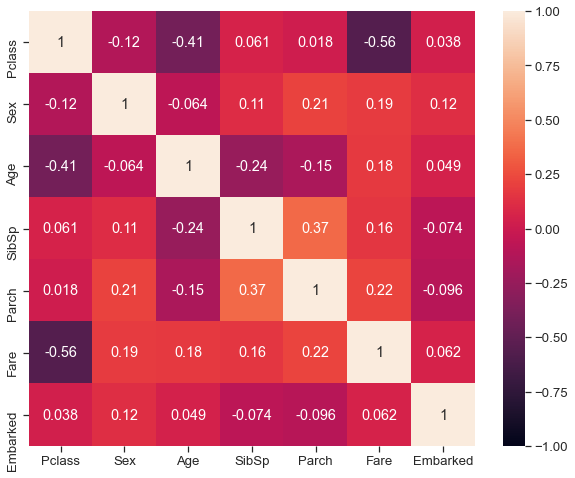

In [62]:
# First we delete the useless feateatures, name and ticket because the can't 
# be used to group age and also cabin a survive features because they have missing values.

df_age_corr = df_all.drop(['Name', 'Ticket','Cabin','Survived'],
                         axis = 1)

plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')

sns.heatmap(df_age_corr.corr(),
           vmin = -1,
           vmax = 1,
           annot = True)

We can identify that the features that shows some correlation with Age are:
- Pclass, strong inverse relation (the higher (1st, 2nd and 3rd) the class the higher the age.
- SibSp, it looks like that travel with spouse (SibSp = 1) might mean that you middle age or more. But if SibSp is higher than one usually you are child traveling with siblings.
- Parch, similar reasoning applies to Parch, just 1 or 2 means you are a child traveling with parents but more means that you have children. Both combined should be quite meaningful.
- Fare, this is very related to Pclass as the higher the class the higher the fare. To be able to group using fare we will need to bin the feature first.

In [63]:
df_age_corr['Fare_bin'] = pd.cut(df_age_corr['Fare'],
                                 5,
                                 labels = [0,1,2,3,4])

df_all['Age'].fillna(df_age_corr.groupby(['Pclass','SibSp','Parch','Fare_bin'])['Age'].transform('median'),
                     inplace = True)

We should confirm that all the missing values have been filled.

In [64]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1307 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 122.7+ KB


There are still two missing values. Let's inspect them one by one to understand why.

In [65]:
df_all[df_all['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1234,NaN,3,"Sage, Mr. John George",0,NaN,1,9,CA. 2343,69.55,NaN,0.0
1257,NaN,3,"Sage, Mrs. John (Annie Bullen)",1,NaN,1,9,CA. 2343,69.55,NaN,0.0


The age of this two passengers are not filled because there is no more passengers with its combination of Pclass, SibSp, Parch and Fare. Therefore I will fill them just using Pclass and Fare to group and extract the data.

In [66]:
df_all['Age'].fillna(df_age_corr.groupby(['Pclass','Fare_bin'])['Age'].transform('median'),
                     inplace = True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 122.7+ KB


Now age feature shows no more missing values.

#### 2.1.5. Embarked

There are just two missing values in embarked feature, initially I would use a similar approach as with Age, but being just two, let's inspect the lines to see if we can do it better.

In [67]:
df_all[df_all['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


They happen to have the same ticket number, therefore they should have embarked from the same place. Looking for the names in internet, they did from Southampton, therefore I can replace NaN with a 0.

In [68]:
df_all['Embarked'].fillna(0, inplace = True)

#### 2.1.6. Cabin

The next feature to correct is embarked but it shows a 77% of missing values. First we should identify if it is worth to spend time on it.

I will start substituting NaN values with Other.

Also the cabin is compound by a letter and a number. The letter is likely to show the area in the boat and then the number should say specifically the room.

They area where you have the room seems that can be important to survive. Depends on how close it is from the deck or if it is closer to the sinking part of the boat, etc.

In [69]:
df_all['Cabin'].fillna('Other', inplace = True)
df_all['Cabin_Letter'] = df_all['Cabin'].str[0]

<AxesSubplot:title={'center':'% of People per Cabin Area'}, xlabel='Cabin_Letter', ylabel='Cabin'>

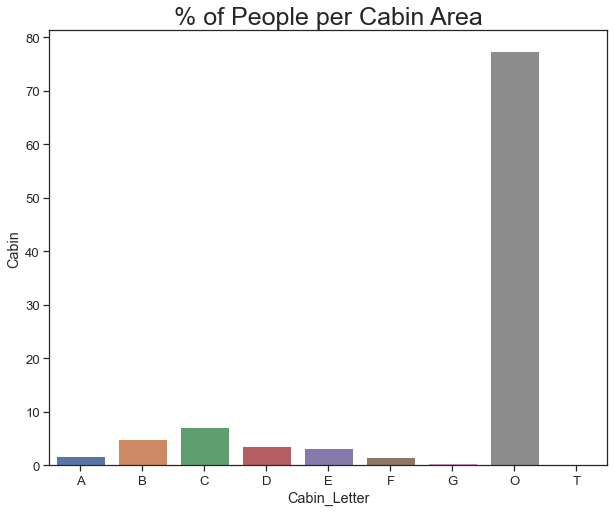

In [70]:
df_all_cabin_count = df_all.groupby(['Cabin_Letter']).count()
df_all_cabin_count = df_all_cabin_count['Cabin'].apply(lambda x: 100*x/df_all.shape[0])

df_all_cabin_count.index

plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('% of People per Cabin Area',
         fontdict = {'fontsize': 25})

sns.barplot(x = df_all_cabin_count.index,
           y = df_all_cabin_count)

As expected most of the passenger are in the missing cabin letter, almost none in G and T and then the other categories are more balanced. Although B and C are very predominant.

The fact that we have so little known values in general and also specifically for some of the categories that are less than 5 makes very difficult to fill the missing values with meaningful data.

From now I will keep the other category and check if cabin letter still provides some meaningful information.

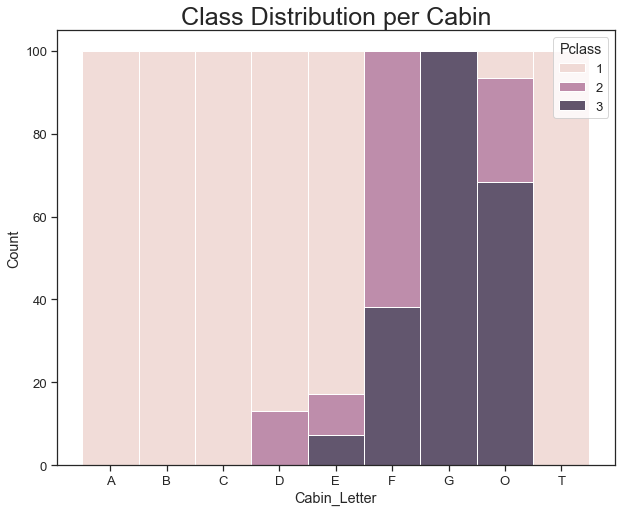

In [71]:
df_all_cabin_Pclass_count = df_all.groupby(['Cabin_Letter','Pclass']).count()
df_all_cabin_Pclass_count.reset_index(inplace = True)

Pclass_perc = []
for index, row in df_all_cabin_Pclass_count.iterrows():
    Pclass_perc.append(100*(row['Cabin']/df_all[df_all['Cabin_Letter'] == row['Cabin_Letter']]['Cabin_Letter'].count()))

df_all_cabin_Pclass_count['Cabin_Perc'] = Pclass_perc
    


plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Class Distribution per Cabin',
         fontdict = {'fontsize': 25})

ax = sns.histplot(df_all_cabin_Pclass_count,
                 x = 'Cabin_Letter',
                 weights = 'Cabin_Perc',
                 hue = 'Pclass',
                 multiple = 'stack',
                 edgecolor = 'white')

We can identify how A, B and C and partially D and F are 1st class cabins, and then F and part of the unknown cabins are 2nd class. G is full 3rd class as well as the unknown part of cabin feature.

The most likely is that the 3rd class passengers were assigned to very crowded cabin areas with lack of registration.

So far we can find some value in cabin feature as it helps to distribute the passengers per class in the ship.

<AxesSubplot:title={'center':'Survived Distribution per Cabin'}, xlabel='Cabin_Letter', ylabel='Count'>

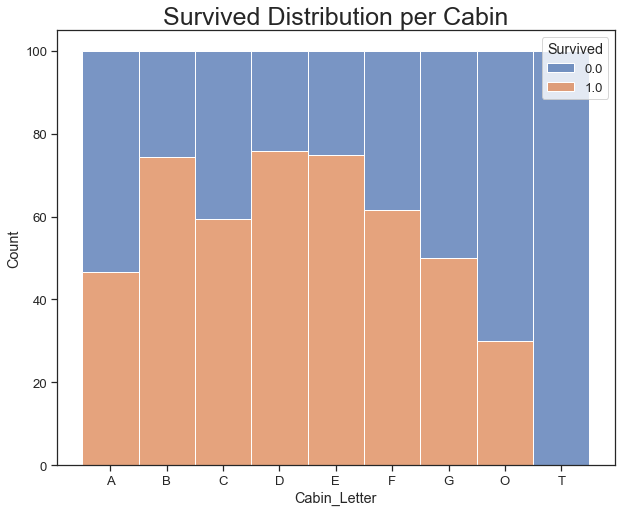

In [73]:
df_all_cabin_Survived_count = df_all.groupby(['Cabin_Letter','Survived']).count()
df_all_cabin_Survived_count.reset_index(inplace = True)

Survived_perc = []
for index, row in df_all_cabin_Survived_count.iterrows():
    Survived_perc.append(100*(row['Cabin']/df_all_cabin_Survived_count[df_all_cabin_Survived_count['Cabin_Letter'] == row['Cabin_Letter']]['Cabin'].sum()))

df_all_cabin_Survived_count['Cabin_Perc'] = Survived_perc
    


plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Survived Distribution per Cabin',
         fontdict = {'fontsize': 25})

sns.histplot(df_all_cabin_Survived_count,
                 x = 'Cabin_Letter',
                 weights = 'Cabin_Perc',
                 hue = 'Survived',
                 multiple = 'stack',
                 edgecolor = 'white')

We can quickly see how some cabins are more likely to survive, possibly because it was easier to get to the deck or because they were far from the first sinking part of the boat.

Also seems that there is some correlation between Survived-Pclass-Cabin, which makes sense.

Looking to these results, we can leave the missing values as other as it still provides some useful information.

To work better with this feature I will map it to convert it to numerical feature.

In [75]:
cabin_dict = {'A': 0, 'B': 1, 'C': 2,'D': 3, 'E': 4, 'F': 5,'G': 6, 'O': 7, 'T': 7}
df_all['Cabin_Letter'] = df_all['Cabin_Letter'].map(cabin_dict)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Pclass        1309 non-null   int64  
 2   Name          1309 non-null   object 
 3   Sex           1309 non-null   int64  
 4   Age           1309 non-null   float64
 5   SibSp         1309 non-null   int64  
 6   Parch         1309 non-null   int64  
 7   Ticket        1309 non-null   object 
 8   Fare          1309 non-null   float64
 9   Cabin         1309 non-null   object 
 10  Embarked      1309 non-null   float64
 11  Cabin_Letter  1309 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 132.9+ KB


Now we can see how all the columns, but Survived, have no missing values.

The next step is to procceed to the exploration analysis.

## 3. Data Exploration

In this step we will try to get a better understanding of each feature and its relation with Survived mainly but also between each other.

First we can start by plotting a similar heatmap as before to identify strong correlations to study.

<AxesSubplot:>

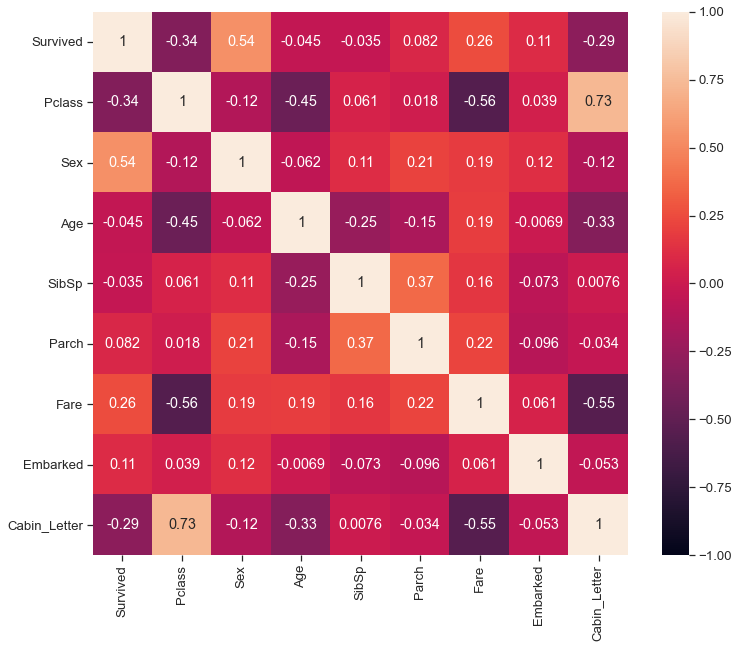

In [76]:
df_age_corr = df_all.drop(['Name', 'Ticket','Cabin'],
                         axis = 1)

plt.figure(figsize = (12,10))
sns.set(font_scale = 1.2)
sns.set_style('ticks')

sns.heatmap(df_age_corr.corr(),
           vmin = -1,
           vmax = 1,
           annot = True)

## 3.1. Pclass

Seems that Pclass has a good correlation with survived, age, fare and Cabin_Letter.

Lets inspect these relations.

<AxesSubplot:title={'center':'Survived Distribution per Passenger Class'}, xlabel='Pclass', ylabel='count'>

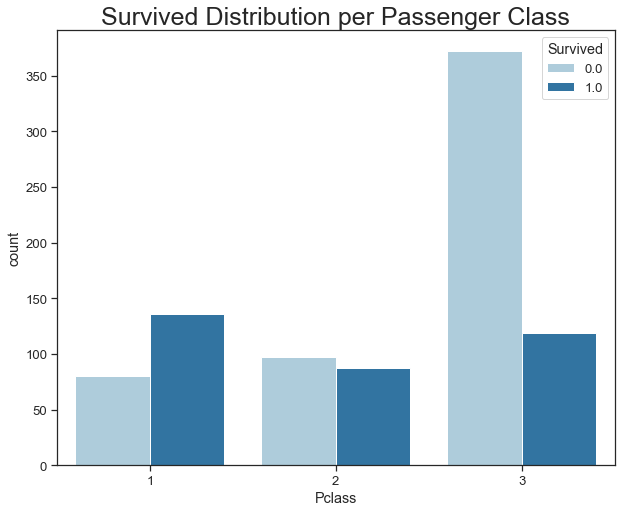

In [77]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Survived Distribution per Passenger Class',
         fontdict = {'fontsize': 25})

sns.countplot(data = df_all,
             x = 'Pclass',
             hue = 'Survived',
             palette = 'Paired')

We can clearly see that socio-economic position matters in order to survive.

1st class shows higher percentage of survived passenger, 2nd class is balanced but 3rd class shows a big difference being quite likely to die if you where in 3rd class.

Text(0.5, 1.0, 'Age Distribution per Passenger Class')

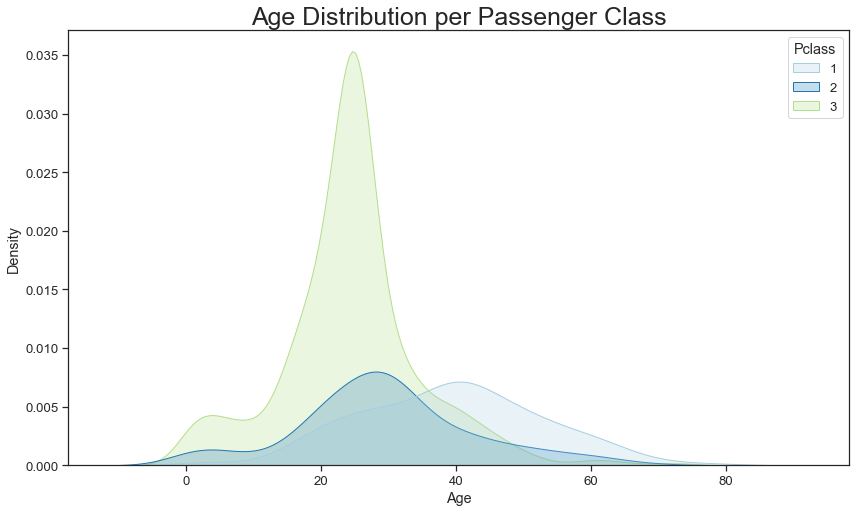

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax = sns.kdeplot(data = df_all,
            x = 'Age',
            hue = 'Pclass',
            palette = 'Paired',
            shade = True)

ax.set_title('Age Distribution per Passenger Class',
             fontsize = 25)